# Cohort 60x60 AUCs using *pH* as a normalizing variable

### Imports and environment setup

- Date of run: 2024-09-26
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/60x60_enlarged_20240926.csv' , sep='\t', index_col=0, header=0)


In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH'
                    'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK',
                    'KPYM_MMK', 'PERM_MMK',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

Could not convert pHMMP9_MMK to float
'pHMMP9_MMK'


In [7]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

In [8]:
# Replace 0s with NaNs in pH column
df_120['pH'] = df_120['pH'].replace(0, np.nan)

In [9]:
# count the number of rows with pH != nan
print('Number of samples with pH values:', df_120['pH'].count())

Number of samples with pH values: 67


# Execution parameters

In [10]:
PLOT_ROCS = True
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/60x60_enlarged_pH_normalizing'

# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK']

NORMALIZING_COL_120 = 'pH' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

MAX_BIOMARKER_COUNT = 3

## Methods

Description of the methods used to compute the AUCS

### Normalized

In this notebook, we're normalizing by *pH* variable, so it doesn't have sense to compute direct or undo dilution methods, that will be the same than in the original notebooks.

In [11]:
METHODS = ['normalized']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

Let's do the same for single biomarkers.

In [12]:
models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            compute_auc_ci=False,
                            auc_threshold=0.0,
                            )

In [13]:
models_120_1 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=1,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            compute_auc_ci=True,
                            auc_threshold=0.0,
                            )

# Results

## Normalized

In [14]:
df_results_120_normalized = pd.read_csv(RESULTS_PATH+'/normalized/max_3.csv', sep=',', header=0)
df_results_120_normalized[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,AGRIN_MMK,PERM_MMK,NaN,0.89961
1,PERM_MMK,NaN,NaN,0.86452
2,KPYM_MMK,PERM_MMK,NaN,0.86186
3,AGRIN_MMK,KPYM_MMK,PERM_MMK,0.86186
4,MMP9_MMK,AGRIN_MMK,NaN,0.83333
5,AGRIN_MMK,NaN,NaN,0.82685
6,AGRIN_MMK,KPYM_MMK,NaN,0.82241
7,MMP9_MMK,AGRIN_MMK,KPYM_MMK,0.80722
8,MMP9_MMK,KPYM_MMK,NaN,0.80627
9,MMP9_MMK,NaN,NaN,0.80556


In [15]:
df_results_120_normalized[df_results_120_normalized['Biomarker_2'].isnull() & df_results_120_normalized['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
1,PERM_MMK,0.86452
5,AGRIN_MMK,0.82685
9,MMP9_MMK,0.80556
16,KPYM_MMK,0.77588
22,HSPB1_MMK,0.75370


## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [16]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

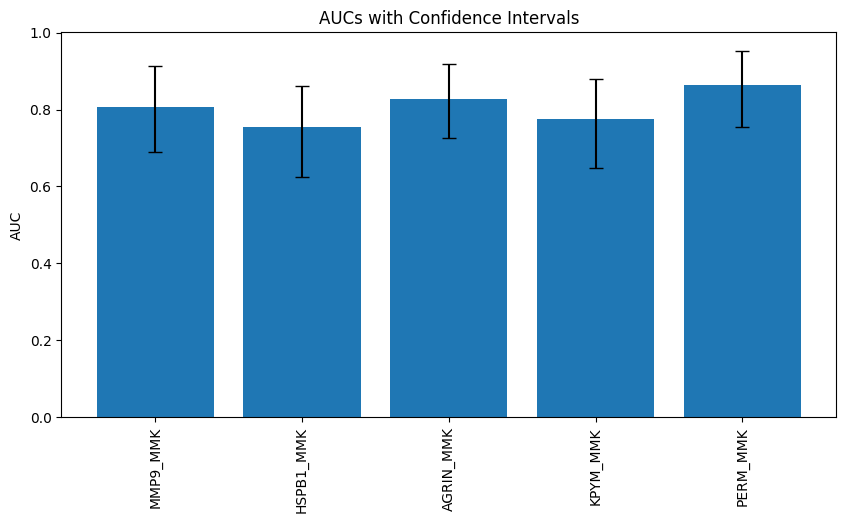

In [17]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center')
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()